In [1]:
# Run this cell to see if fmm is installed properly.
# If it fails, you won't be able to run the cells using fmm

! fmm

[info][fmm_app_config.cpp:49 ] Start reading FMM configuration from arguments
fmm argument lists:
--ubodt (required) <string>: Ubodt file name
--network (required) <string>: Network file name
--network_id (optional) <string>: Network id name (id)
--source (optional) <string>: Network source name (source)
--target (optional) <string>: Network target name (target)
--gps (required) <string>: GPS file name
--gps_id (optional) <string>: GPS id name (id)
--gps_x (optional) <string>: GPS x name (x)
--gps_y (optional) <string>: GPS y name (y)
--gps_timestamp (optional) <string>: GPS timestamp name (timestamp)
--gps_geom (optional) <string>: GPS geometry name (geom)
--gps_point (optional): if specified read input data as gps point, otherwise (default) read input data as trajectory
--output (required) <string>: Output file name
--output_fields (optional) <string>: Output fields
  opath,cpath,tpath,mgeom,pgeom,
  offset,error,spdist,tp,ep,length,duration,speed,all
-k/--candidates (optional) <int>

## A New Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [2]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt

%matplotlib inline
ox.__version__

if not os.path.exists("temp/"):
    os.makedirs("temp/")


/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


First, we download from OSM a street map for a section of Sendai, JP-- particularly, the area around Tohoku University. However, OSMnx by default does not track directionality of roads-- this is an important factor when map matching, so we use a script created by cyang-kth for their fmm program which saves this information.

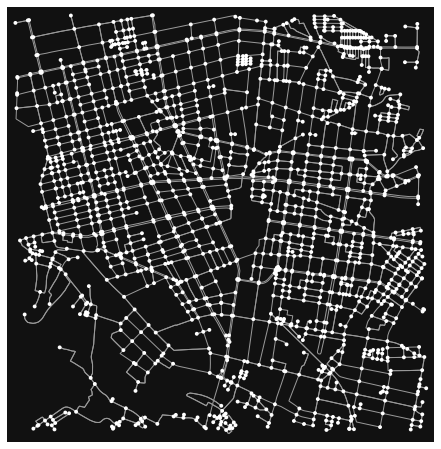

/tmp/ipykernel_207776/955767582.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


In [3]:
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)


S = ox.graph_from_address("Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",dist=1750, network_type='drive')
fig, ax = ox.plot_graph(S)

save_graph_shapefile_directional(S, filepath='Tohoku')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects mathematically, we will need to convert this to `GeoDataFrame`. 

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(S)
gdf_nodes.head()

,y,x,highway,street_count,geometry
osmid,,,,,
244879417,38.266126,140.871677,traffic_signals,4,POINT (140.87168 38.26613)
244879418,38.260102,140.875203,traffic_signals,4,POINT (140.87520 38.26010)
301789611,38.256070,140.873493,traffic_signals,4,POINT (140.87349 38.25607)
301789618,38.255104,140.875946,NaN,4,POINT (140.87595 38.25510)
301789634,38.252816,140.879493,traffic_signals,4,POINT (140.87949 38.25282)


In [5]:
gdf_edges.head()

osmid  oneway     ref   name   highway maxspeed  \
u         v          key                                                        
244879417 1201390811 0    218028552    True      45   定禅寺通     trunk       60   
          4025385190 0    461330966    True  286;48  東二番丁通     trunk       60   
244879418 1201358483 0     30999231    True     NaN    青葉通  tertiary      NaN   
          1256397159 0    899682371    True     286  東二番丁通     trunk       60   
301789611 1837893264 0    837910375   False     NaN    NaN  tertiary      NaN   

                         reversed  length  \
u         v          key                    
244879417 1201390811 0      False  17.586   
          4025385190 0      False  66.732   
244879418 1201358483 0      False  15.304   
          1256397159 0      False  94.102   
301789611 1837893264 0       True  11.727   

                                                                   geometry  \
u         v          key                                                      
244879417 1201390811 0    LINESTRING (140.87168 38.26613, 140.87148 38.2...   
          4025385190 0    LINESTRING (140.87168 38.26613, 140.87178 38.2...   
244879418 1201358483 0    LINESTRING (140.87520 38.26010, 140.87503 38.2...   
          1256397159 0    LINESTRING (140.87520 38.26010, 140.87564 38.2...   
301789611 1837893264 0    LINESTRING (140.87349 38.25607, 140.87347 38.2...   

                         lanes bridge tunnel  
u         v          key                      
244879417 1201390811 0     NaN    NaN    NaN  
          4025385190 0     NaN    NaN    NaN  
244879418 1201358483 0       4    NaN    NaN  
          1256397159 0     NaN    NaN    NaN  
301789611 1837893264 0     NaN    NaN    NaN

Now let's look at the GPS data from a day walking around Sendai.

In [6]:
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

# Read file from KML
fp = "history-2022-06-21.kml"
tripdata = gpd.read_file(fp, driver='KML')

<AxesSubplot:>

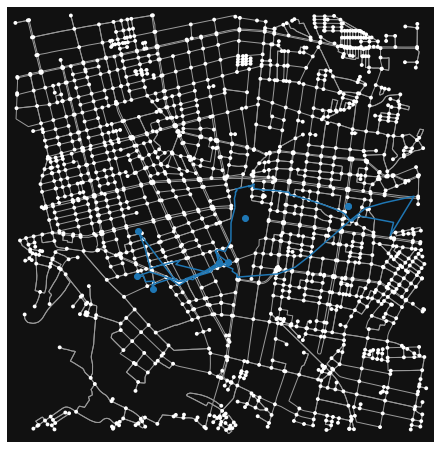

In [7]:
fig, ax = ox.plot_graph(S,show=False, close=False)
tripdata.plot(ax=ax)

Now we will run this information through FMM as a baseline. To do this we will first need to convert our GeoDataFrame to a Shapefile.

In [8]:
# Simplify tripdata to only LineStrings
td = tripdata[tripdata.geom_type == 'LineString'].geometry

# Write to Shapefile (just make a copy)
outfp = "temp/history-2022-06-21.shp"
td.to_file(outfp)

Because FMM uses the same network datatype as us, we do not need to make any modifications to our network. Now we are ready to use FMM.

In [9]:
from fmm import Network,NetworkGraph,FastMapMatch,UBODTGenAlgorithm,UBODT,FastMapMatchConfig,GPSConfig,ResultConfig

In [10]:
network = Network("Tohoku/edges.shp","fid","u","v")
print ("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

Nodes 1691 edges 3949
[2022-07-08 16:57:45.134] [info] [network.cpp:72] Read network from file Tohoku/edges.shp
[2022-07-08 16:57:45.150] [info] [network.cpp:170] Number of edges 3949 nodes 1691
[2022-07-08 16:57:45.150] [info] [network.cpp:171] Field index: id 14 source 0 target 1
[2022-07-08 16:57:45.152] [info] [network.cpp:174] Read network done.
[2022-07-08 16:57:45.153] [info] [network_graph.cpp:17] Construct graph from network edges start
[2022-07-08 16:57:45.153] [info] [network_graph.cpp:30] Graph nodes 1691 edges 3949
[2022-07-08 16:57:45.153] [info] [network_graph.cpp:31] Construct graph from network edges end


In [11]:
### Precompute an UBODT table

# Can be skipped if you already generated an ubodt file
ubodt_gen = UBODTGenAlgorithm(network,graph)
status = ubodt_gen.generate_ubodt("temp/ubodt.txt", 0.02, binary=False, use_omp=True)
print(status)

[2022-07-08 16:57:45.160] [info] [ubodt_gen_algorithm.cpp:76] Start to generate UBODT with delta 0.02
[2022-07-08 16:57:45.160] [info] [ubodt_gen_algorithm.cpp:77] Output format csv
[2022-07-08 16:57:45.244] [info] [ubodt_gen_algorithm.cpp:105] Progress 169 / 1691
[2022-07-08 16:57:45.336] [info] [ubodt_gen_algorithm.cpp:105] Progress 338 / 1691
[2022-07-08 16:57:45.417] [info] [ubodt_gen_algorithm.cpp:105] Progress 507 / 1691
[2022-07-08 16:57:45.500] [info] [ubodt_gen_algorithm.cpp:105] Progress 676 / 1691
[2022-07-08 16:57:45.593] [info] [ubodt_gen_algorithm.cpp:105] Progress 845 / 1691
[2022-07-08 16:57:45.695] [info] [ubodt_gen_algorithm.cpp:105] Progress 1014 / 1691
[2022-07-08 16:57:45.799] [info] [ubodt_gen_algorithm.cpp:105] Progress 1183 / 1691
[2022-07-08 16:57:45.900] [info] [ubodt_gen_algorithm.cpp:105] Progress 1352 / 1691
[2022-07-08 16:57:46.001] [info] [ubodt_gen_algorithm.cpp:105] Progress 1521 / 1691
Status: success
Time takes 0.949 seconds



In [12]:
### Read UBODT

ubodt = UBODT.read_ubodt_csv("temp/ubodt.txt")

[2022-07-08 16:57:46.121] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from temp/ubodt.txt
[2022-07-08 16:57:46.645] [info] [ubodt.cpp:236] Read rows 1000000
[2022-07-08 16:57:46.742] [info] [ubodt.cpp:243] Finish reading UBODT with rows 1188142


In [13]:
### Create FMM model
model = FastMapMatch(network,graph,ubodt)

### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005
fmm_config = FastMapMatchConfig(k,radius,gps_error)

In [14]:
input_config = GPSConfig()
input_config.file = "temp/history-2022-06-21.shp"
input_config.id = "FID"

result_config = ResultConfig()
result_config.file = "temp/mr.csv"
result_config.output_config.write_opath = True
print(result_config.to_string())

result = model.match_gps_file(input_config, result_config, fmm_config)

Result file : temp/mr.csv
Output fields: opath cpath mgeom 
[2022-07-08 16:57:46.758] [info] [gps_reader.cpp:337] GPS data in trajectory shapefile format
[2022-07-08 16:57:46.758] [info] [gps_reader.cpp:45] Read trajectory from file temp/history-2022-06-21.shp
[2022-07-08 16:57:46.759] [warning] [gps_reader.cpp:69] Timestamp column timestamp not found
[2022-07-08 16:57:46.759] [info] [gps_reader.cpp:81] Total number of trajectories 10
[2022-07-08 16:57:46.759] [info] [gps_reader.cpp:82] Finish reading meta data


In [15]:
tripdata.geometry

0                  POINT Z (140.87990 38.25672 0.00000)
1     LINESTRING Z (140.87990 38.25672 0.00000, 140....
2                  POINT Z (140.89238 38.26100 0.00000)
3     LINESTRING Z (140.89354 38.26051 0.00000, 140....
4                  POINT Z (140.89238 38.26100 0.00000)
5     LINESTRING Z (140.89337 38.26027 0.00000, 140....
6                  POINT Z (140.88244 38.26013 0.00000)
7     LINESTRING Z (140.88147 38.26088 0.00000, 140....
8                  POINT Z (140.87990 38.25672 0.00000)
9     LINESTRING Z (140.87990 38.25672 0.00000, 140....
10                 POINT Z (140.87361 38.25473 0.00000)
11    LINESTRING Z (140.87361 38.25473 0.00000, 140....
12                 POINT Z (140.87209 38.25570 0.00000)
13    LINESTRING Z (140.87209 38.25570 0.00000, 140....
14                 POINT Z (140.87990 38.25672 0.00000)
15    LINESTRING Z (140.87990 38.25672 0.00000, 140....
16                 POINT Z (140.87213 38.25909 0.00000)
17    LINESTRING Z (140.87213 38.25909 0.00000, 

In [16]:
### First we apply post-processing to the result...

resultdf = pd.read_csv("temp/mr.csv", sep=";")

def extract_cpath(cpath):
    if (cpath==''):
        return []
    return [int(s) for s in cpath.split(',')]

# Extract cpath as list of int
resultdf["cpath_list"] = resultdf.apply(lambda row: extract_cpath(row.cpath), axis=1)

# Extract all the edges matched
all_edge_ids = np.unique(np.hstack(resultdf.cpath_list)).tolist()

# Import our network edges
network_gdf = gpd.read_file("Tohoku/edges.shp")
network_gdf.fid = network_gdf.fid.astype(int)

edges_df = network_gdf[network_gdf.fid.isin(all_edge_ids)].reset_index()
edges_df["points"] = edges_df.apply(lambda row: len(row.geometry.coords), axis=1)
edges_df.head()

,index,u,v,key,osmid,oneway,ref,name,highway,maxspeed,reversed,length,lanes,bridge,tunnel,fid,geometry,points
0,8,301789618,1264086390,0,32896012,1,None,五橋通,tertiary,None,False,114.691,2,None,None,8,"LINESTRING (140.87595 38.25510, 140.87576 38.2...",4
1,30,338511386,1256434361,0,837910348,0,None,北目町通,tertiary,None,False,58.172,None,None,None,30,"LINESTRING (140.87916 38.25612, 140.87921 38.2...",3
2,31,338511386,338511390,0,837910348,0,None,北目町通,tertiary,None,True,129.642,None,None,None,31,"LINESTRING (140.87916 38.25612, 140.87909 38.2...",4
3,33,338511388,338511389,0,30614284,1,None,東四番丁線,unclassified,None,False,145.386,None,None,None,33,"LINESTRING (140.87972 38.25768, 140.87975 38.2...",4
4,36,338511389,1257468277,0,837910348,0,None,北目町通,tertiary,None,False,53.640,None,None,None,36,"LINESTRING (140.88043 38.25649, 140.88100 38.2...",2


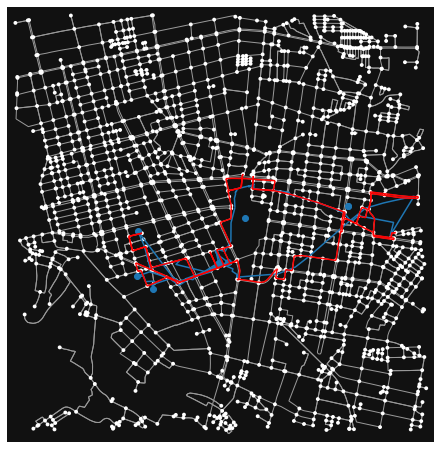

In [17]:
fig, ax = ox.plot_graph(S,show=False, close=False)
tripdata.plot(ax=ax)
edges_df.plot(ax=ax, color="red")

edges_df.to_csv("result.csv",sep=";",index=False)

In [18]:
!rm -r temp